# Sensor Data and Deep Learning 3: Convolution Neural Network and Recurrent Neural Network
*This material is a joint work of TAs from IC Lab at KAIST, including Woohyeok  Choi, Soowon Kang, Auk Kim, Inyeob Kim, Minhyung Kim, Hansoo Lee, Cheul Y. Park, and Eunji Park. This work is licensed under CC BY-SA 4.0.*


In [1]:
%pip install numpy pandas scikit-learn plotly

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

## Purpose of Today's Lab
* Getting *more and more familiar* with Pytorch programming interface.
* Building and evaluating a convolution neural network and recurrent neural network for human activity recognition (HAR).
* **IMPORTANT**: One homework (until May 23) and one nano-quiz (on May 19).

## Convolution Neural Network (CNN)


### Background

Throughout the previous two lectures, we have covered a regular neural network in which each input has a corresponding weight. While this architecture worked well, there are many weights we should optimize. Remember? We had to train about 280,000 parameters for just classifying 28x28 pixels of grayscale images! What if we want to classify HD images? We may need to train billions of parameters.

Instead of one-to-one mapping between inputs and weights, what if we can reduce the number of weights? Then, we may boost training speed, consume fewer resources/time, and mitigate overfitting if possible. But is it possible? Yeah, in the world of convolution neural networks, it is possible!

#### Convolution Layer

Literally, the core of the *convolution* neural network is *the convolution layer*. This layer converts local receptive field inputs into output filter maps via filters. What? Receptive field? Filter? Filter map? The CNN contains several unique concepts that seem difficult to understand. However, the example below may help you know them.


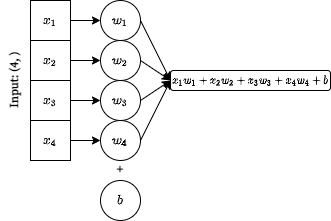


The figure above shows a typical layer architecture that we have covered. Each input has a corresponding weight, and thus the number of weights that we have to optimize is equal to the input size.

If we can reduce the number of weights by half, it may be feasible to handle large image inputs. Let's see the architecture below.


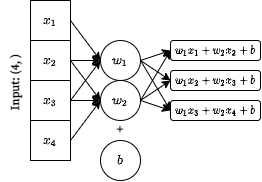


This architecture has only two weights, in which *some inputs share weights with other inputs*. In addition, it gives three outputs instead of a single output in the previous architecture. Likewise, we can reduce the number of parameters we should train. However, is it right to do? It is possible in the convolution neural network *if some inputs are related to other inputs*.


##### 1-D Convolution Layer

###### Simple Example: 1-D Input

Let's reorganize the previous architecture as below: 1-D convolution layer.

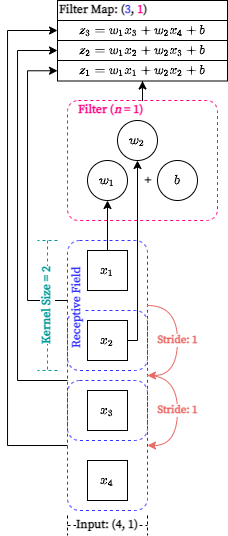

Let's suppose our input, $x_{t}$, is a heart rate value collected at time $t$. Then, $x_{t}$ and $x_{t+1}$ may be highly related because they are collected from the same data source (i.e., heart rate) and temporally close (i.e., $t$ and $t+1$). Therefore, we may think that some features can be extracted within $x_{t}$ and $x_{t+1}$, like feature extraction from a time window in the supervised learning lecture. Such a window is called *receptive field*, and the window size is called *kernel size* in the CNN. We can also *move* the window like a sliding window, called *stride* in the CNN. As a regular neural network, CNN calculates a weighted sum of inputs within the receptive field. A set of weights is called *filter*, and outputs are called *filter map* in the CNN.

Then, let's see how we implement a convolution layer in pytorch. First, we will build the layer same as the figure above:
* Four 1-D inputs from the same source (i.e., 1 column and 4 rows) come into the layer:
```python
input_shape = (4,1)
```
* The receptive field includes 2 rows of inputs (and thus, the kernel size is 2):
```python
kernel_size = 2
```
* The receptive field slides by one row:
```python
strides = 1
```
* There is only a single filter:
```python
filters = 1
```

In [3]:
# Define the model
class Conv1DModel(nn.Module):
    def __init__(self):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=1,  # equivalent to 1 column
            out_channels=1, # number of filters
            kernel_size=2,  # window size
            stride=1        # sliding step
        )

    def forward(self, x):
        return self.conv1(x)

# Create the model instance
model = Conv1DModel()

# Print model summary-like info
print(model)

# Optional: test with dummy input
x_dummy = torch.randn(1, 1, 4)  # batch_size=1, channels=1, sequence_length=4
output = model(x_dummy)
print("Input shape:", x_dummy.shape)
print("Output shape:", output.shape)

Conv1DModel(
  (conv1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
)
Input shape: torch.Size([1, 1, 4])
Output shape: torch.Size([1, 1, 3])


The output shape and the number of parameters in the model are exactly the same as the figure, right?

###### Generalized 1-D Convolution Layer

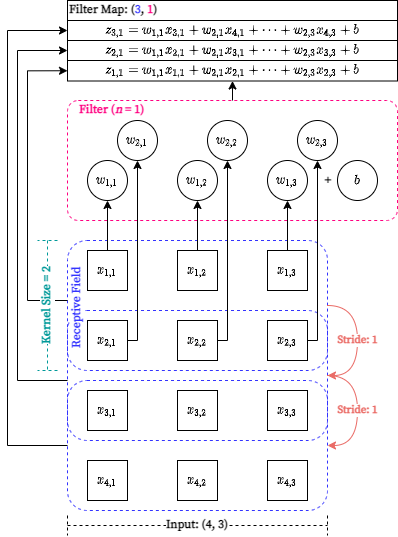

If you have multi-dimensional inputs, the receptive field of the 1-D convolution layer contains all dimensional inputs. For example, if you have four 3-D inputs above and the kernel size is 2, the 1-D convolution layer calculates a weighted sum of all inputs within two rows.


Let's check whether it is correct via the codes below.


In [4]:
# Define the model
class Conv1DModel(nn.Module):
    def __init__(self):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=3,  # 3 channels/features per time step
            out_channels=1, # number of filters
            kernel_size=2,  # window size
            stride=1        # sliding step
        )

    def forward(self, x):
        return self.conv1(x)

# Create the model instance
model = Conv1DModel()

# Print model architecture
print(model)

# Optional: test with dummy input
# PyTorch expects: (batch_size, channels=3, length=4)
x_dummy = torch.randn(1, 3, 4)  # batch_size=1
output = model(x_dummy)
print("Input shape:", x_dummy.shape)
print("Output shape:", output.shape)


Conv1DModel(
  (conv1): Conv1d(3, 1, kernel_size=(2,), stride=(1,))
)
Input shape: torch.Size([1, 3, 4])
Output shape: torch.Size([1, 1, 3])


The number of parameters is 7: 1 (# Filters) x 7 (2 kernel size x 3 columns + 1 bias)

In addition, we can consider multiple filters, as below.


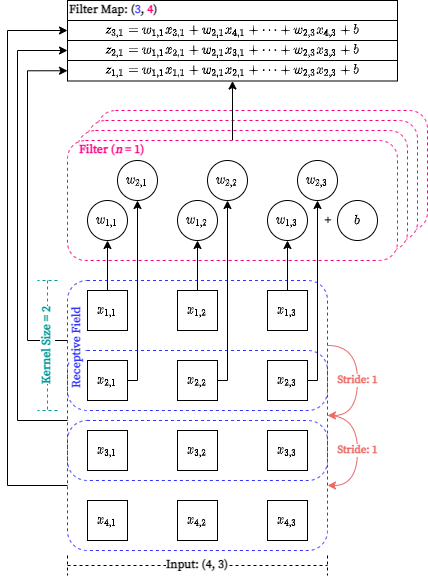

In [5]:
import torch
import torch.nn as nn

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the PyTorch Conv1D model
class Conv1DModel(nn.Module):
    def __init__(self):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=3,
            out_channels=4,   # Number of filters
            kernel_size=2,    # Receptive field size
            stride=1          # Sliding size
        )

    def forward(self, x):
        return self.conv1(x)

# Instantiate the model
model = Conv1DModel()

# Print model structure
print(model)

x_dummy = torch.randn(1, 3, 4)  # batch=1, in_channels=3, sequence length=4
output = model(x_dummy)
print("Input shape:", x_dummy.shape)
print("Output shape:", output.shape)


Conv1DModel(
  (conv1): Conv1d(3, 4, kernel_size=(2,), stride=(1,))
)
Input shape: torch.Size([1, 3, 4])
Output shape: torch.Size([1, 4, 3])


The number of parameters is 28: 4 (# Filters) x 7 (2 kernel size x 3 columns + 1 bias). In addition, you can see that *the output shape is changed: (3, **4**)*. The times that the receptive field can slide correspond to *the number of rows*, and the number of filters is equal to *the number of columns* in the output shape.

As such, the 1-D convolution layer can be used to handle *a time-series data*, in which there is a *temporal relationship* between data. For example, suppose acceleration values from 3 axes (i.e., x, y, and z) are collected every second, and you want to classify a current activity using accelerations collected for 4 seconds. Then, the convolution layer receives inputs composed of 4 rows (i.e., values for 4 seconds) and 3 columns (i.e., x, y, and z).

##### $n$-D Convolution Layer
We allowed the 1-D receptive field to slide row-wise because we suppose our input is time-series data. What about image data? As you know, in the image, each pixel may have a spatial relationship with nearby pixels. Therefore, we may need to slide *the 2-D receptive field row- and column-wise*. *2-D convolution layer* performs such operations. Of course, we can think about *3-D convolution layer* in which 3-D receptive fields move by row-, column-, and an orthogonal direction to both row and column.


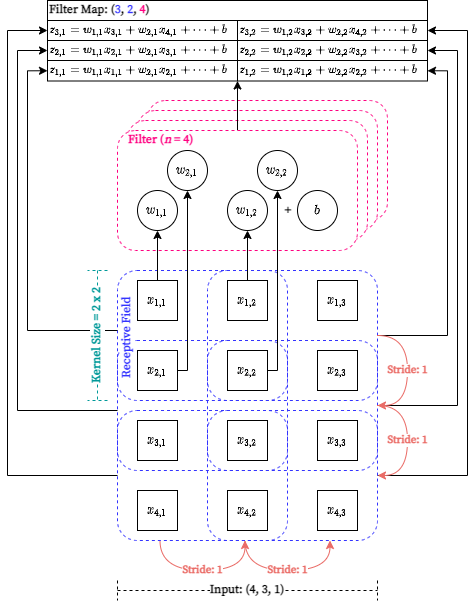

The example above shows how the 2-D convolution layer works. This layer has *2 x 2 kernel size* and *4 filters*. The receptive field slides by one step in a row- and column-wise directions.

Then, let's implement the layer above in pytorch.

In [6]:
import torch
import torch.nn as nn

# Set seed for reproducibility
torch.manual_seed(42)

class Conv2DModel1(nn.Module):
    def __init__(self):
        super(Conv2DModel1, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=1,      # channels = 1
            out_channels=4,     # filters = 4
            kernel_size=(2, 2),
            stride=1
        )

    def forward(self, x):
        return self.conv(x)

model1 = Conv2DModel1()
print(model1)

# Dummy input: (batch_size, channels, height, width)
x1 = torch.randn(1, 1, 4, 3)
y1 = model1(x1)
print("Input shape:", x1.shape)
print("Output shape:", y1.shape)


Conv2DModel1(
  (conv): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1))
)
Input shape: torch.Size([1, 1, 4, 3])
Output shape: torch.Size([1, 4, 3, 2])


The number of parameters is 20: 4 (# Filters) x 5 (2 x 2 kernel size x 1 channel + 1 bias)

We note that we need to define input shape as a tuple of three integers, *the number of rows, the number of columns, and a dimension that is orthogonal to rows and columns*. The last dimension is typically called the channel in the 2-D convolution layer.

In the previous example of the 1-D convolution layer, you defined an input shape as a tuple of the number of rows and the number of columns, like (4, 3). For each column (i.e., the last number of the shape), you perform convolution operations on 4 rows (i.e., the first number of the shape).

Now, let's see the 2-D convolution layer, like (4, 3, 1). For each channel (i.e., the last number of the shape), you perform convolution operations on 4x3 matrix (i.e., the first two numbers of the shape).

If you increase the number of channels:


In [7]:
class Conv2DModel2(nn.Module):
    def __init__(self):
        super(Conv2DModel2, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=5,      # channels = 5
            out_channels=4,     # filters = 4
            kernel_size=(2, 2),
            stride=1
        )

    def forward(self, x):
        return self.conv(x)

model2 = Conv2DModel2()
print(model2)

# Dummy input: (batch_size, channels, height, width)
x2 = torch.randn(1, 5, 4, 3)
y2 = model2(x2)
print("Input shape:", x2.shape)
print("Output shape:", y2.shape)


Conv2DModel2(
  (conv): Conv2d(5, 4, kernel_size=(2, 2), stride=(1, 1))
)
Input shape: torch.Size([1, 5, 4, 3])
Output shape: torch.Size([1, 4, 3, 2])



The number of parameters is 20: 4 (# Filters) x 21 (2 x 2 kernel size x 5 channels + 1 bias)

##### Zero-Padding
Let's come back to the 1-D convolution layer.



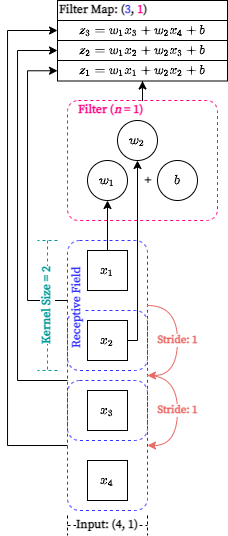그림


As shown above, our input dimension is reduced from 4 to 3 via the convolution layer. What if we use a larger kernel size, like 3 instead of 2?


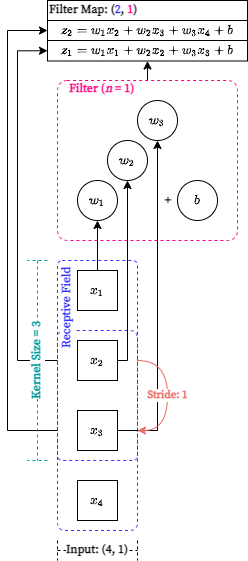


Yeah, we can get the smaller size of outputs. As such, an increase in the kernel size reduces the convolution output size. Is it good? Maybe not. If you stack multiple convolution layers, your inputs will become smaller and smaller, eventually disappearing. We do not want our input to go somewhere.


What if we increase strides from 1 to 2?

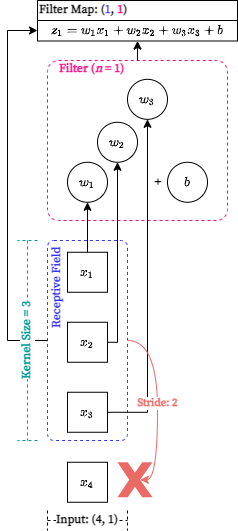

We can perform the first convolution operation, but there are insufficient inputs for the subsequent convolution. Therefore, we cannot perform convolution operations and will lose the information of such a receptive field. As we learned in the signal processing lecture, a solution for addressing these problems is *zero-padding* which puts some zeros at the start or end of inputs.

Let's see how zero padding can maintain an input size:

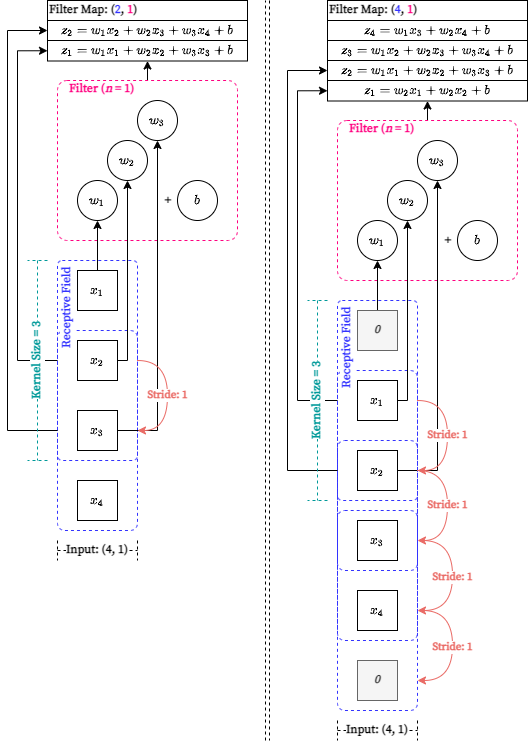

As shown above, we can get an output whose size is equal to the input size by padding zeros at the input's start and end.

What about a larger stride?


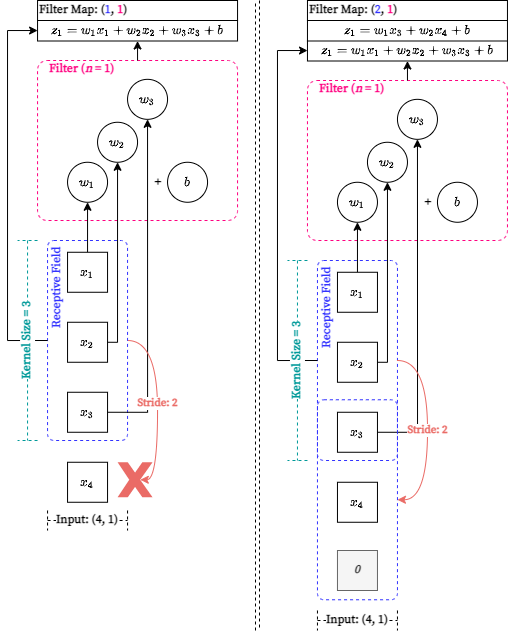

By putting a zero at the end of the input, the receptive field can slide two times so that $x_4$ is used to calculate a filter map.

Here is an equation for an output length of the convolution layer:
* Without zero-padding:
$$
\lfloor \frac{\text{input_length} + \text{strides} - \text{kernel_size}}{\text{strides}} \rfloor
$$

* With zero-padding:
$$
\lfloor \frac{\text{input_length} + \text{strides} - 1}{\text{strides}} \rfloor
$$

As shown in the equation, if the receptive field slides by one (i.e., strides = 1), you can get an output whose size is equal to the input size with zero padding.

Then, how can we implement zero-padding in pytorch? You just need to set the argument, *padding*, as "*same*" (or, if you do not want zero-padding, you set "padding" as "valid").




In [8]:
import torch
import torch.nn as nn

# Case 1: Without zero padding
print('# W/O Zero padding')

model_valid = nn.Sequential(
    nn.Conv1d(
        in_channels=1,
        out_channels=1,
        kernel_size=3,
        stride=1,
        padding=0  # No padding
    )
)
print(model_valid)

# Check output shape
x = torch.randn(1, 1, 4)  # (batch_size, channels, length)
out = model_valid(x)
print(f'Input shape: {x.shape}, Output shape: {out.shape}\n')

# Case 2: With zero padding
print('# W/ Zero padding')

# Padding='same' requires computing padding dynamically if stride != 1 or kernel_size is odd
# But since kernel_size=3, stride=1, PyTorch's padding=1 works for 'same'
model_same = nn.Sequential(
    nn.Conv1d(
        in_channels=1,
        out_channels=1,
        kernel_size=3,
        stride=1,
        padding=1  # 'same' padding to maintain input length
    )
)
print(model_same)

x = torch.randn(1, 1, 4)
out = model_same(x)
print(f'Input shape: {x.shape}, Output shape: {out.shape}')


# W/O Zero padding
Sequential(
  (0): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
)
Input shape: torch.Size([1, 1, 4]), Output shape: torch.Size([1, 1, 2])

# W/ Zero padding
Sequential(
  (0): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)
Input shape: torch.Size([1, 1, 4]), Output shape: torch.Size([1, 1, 4])


#### Pooling Layer
The convolution layer extracts important information considering the spatial or temporal relationship between data. However, the size of inputs remains large if we use zero-padding with one stride. The large input size corresponds to the large number of parameters we should optimize, and thus, we need a longer duration and more extensive resources for training the CNN.

The most obvious way to reduce the number of parameters is to shrink the input size. However, at the same time, we want to keep important information even if we reduce the input size. This is the role of the pooling layer.

The operations conducted in the pooling layer are simple: As similar to typical feature extraction, the pooling layer extracts statistics (e.g., mean, max, min) from a sliding window (i.e., the receptive field with strides). The popular operation for the pooling layer is to get the maximum (called *Max Pooling Layer*) or mean (called *Average Pooling Layer*) from inputs in a receptive field. Interestingly, the max-pooling layer works better in practice than the average pooling layer.


###### 1-D Pooling Layer

Let's see the example, 1-D pooling layer on 1-D input:


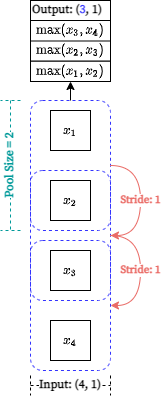

As shown above, the pooling layer has *pool size*, which is similar to the kernel size of the convolution layer, and *strides*, which acts the same as the convolution layer. However, the pooling layer does not have parameters that we should train via backpropagation because its outputs depend on the inputs' statistical distribution, not the loss function.

Then, let's implement the pooling layer in pytorch.

In [9]:
import torch
import torch.nn as nn

class Conv1DNoPadding(nn.Module):
    def __init__(self):
        super(Conv1DNoPadding, self).__init__()
        self.conv = nn.Conv1d(
            in_channels=1,
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=0  # "valid" means no padding
        )

    def forward(self, x):
        return self.conv(x)

model_no_pad = Conv1DNoPadding()
print("# W/O Zero padding")
print(model_no_pad)

x = torch.randn(1, 1, 4)  # (batch, channels, length)
y = model_no_pad(x)
print("Input shape:", x.shape)
print("Output shape:", y.shape)


# W/O Zero padding
Conv1DNoPadding(
  (conv): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
)
Input shape: torch.Size([1, 1, 4])
Output shape: torch.Size([1, 1, 2])


As shown above, there is no parameter we need to train.

Another example, a 1-D pooling layer on 3-D input with 2 strides, is as below:

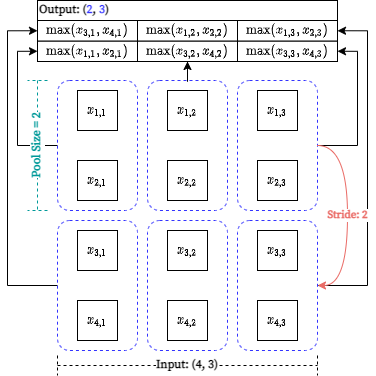

In [10]:
class MaxPool1DModel(nn.Module):
    def __init__(self):
        super(MaxPool1DModel, self).__init__()
        self.pool = nn.MaxPool1d(
            kernel_size=2,
            stride=1
        )

    def forward(self, x):
        return self.pool(x)

model_pool = MaxPool1DModel()
print("\n# MaxPool1D")
print(model_pool)

x = torch.randn(1, 1, 4)  # (batch, channels, length)
y = model_pool(x)
print("Input shape:", x.shape)
print("Output shape:", y.shape)



# MaxPool1D
MaxPool1DModel(
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
)
Input shape: torch.Size([1, 1, 4])
Output shape: torch.Size([1, 1, 3])


Unlike the 1-D convolution layer, the 1-D pooling layer does not calculate a weighted sum of inputs based on filters, and thus, the output shape solely depends on the input shape.

###### $n$-D Pooling Layer
Of course, we can think 2-D pooling layer, as below:

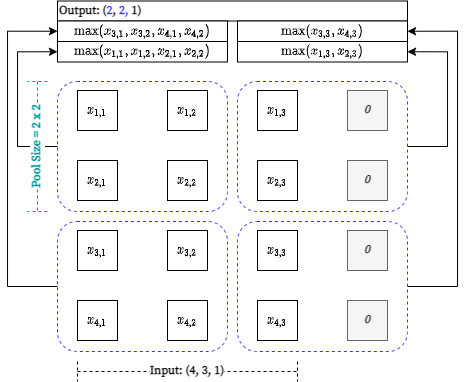

As shown above, the pooling layer also supports *zero-padding*.

In [11]:
import torch
import torch.nn as nn

# Define PyTorch MaxPool2D model
class MaxPool2DModel(nn.Module):
    def __init__(self):
        super(MaxPool2DModel, self).__init__()
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2,
            padding=0
        )

    def forward(self, x):
        return self.pool(x)

def same_pad_2d(x, kernel_size, stride):
    h, w = x.shape[-2:]
    pad_h = max((h - 1) // stride * stride + kernel_size - h, 0)
    pad_w = max((w - 1) // stride * stride + kernel_size - w, 0)
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    return nn.functional.pad(x, (pad_left, pad_right, pad_top, pad_bottom))

# Instantiate model
model = MaxPool2DModel()
print(model)

# Dummy input: (batch, channels, height, width)
x = torch.randn(1, 1, 4, 3)
x_padded = same_pad_2d(x, kernel_size=2, stride=2)
y = model(x_padded)

print("Input shape:", x.shape)
print("After same padding shape:", x_padded.shape)
print("Output shape:", y.shape)


MaxPool2DModel(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Input shape: torch.Size([1, 1, 4, 3])
After same padding shape: torch.Size([1, 1, 4, 4])
Output shape: torch.Size([1, 1, 2, 2])


Note that *the size of strides is equal to the pool_size* in the case of a typical CNN.


### Example of CNN Architecture: Fashion MNIST
Then, let's see the actual example of the CNN architecture for handling the Fashion MNIST dataset.

###### Preparation
First, we will prepare the Fashion MNIST dataset.


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split



# Transform: normalize pixel values from [0, 255] → [0.0, 1.0]
transform = transforms.Compose([
    transforms.ToTensor(),  # converts to shape (C, H, W) and scales to [0.0, 1.0]
    transforms.Lambda(lambda x: x.view(-1))  # flatten to 784
])

# Load dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 196kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.0MB/s]


Typically, the training of CNN is terribly slow because CNN has lots of matrix multiplication. Therefore, we need the help of special hardware that can well handle the matrix multiplication: the Graphics Processing Unit (GPU).

To use GPU in the Colab, you must first change a runtime type into the GPU: Runtime (in the menu bar) - Change Runtime Type - Hardware Accelerator - GPU.

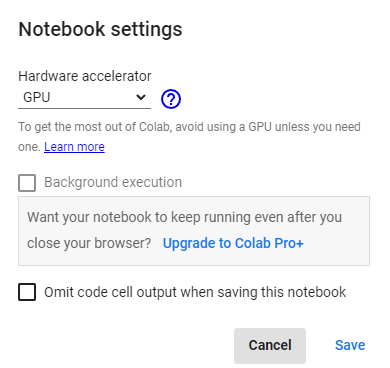

And then, check whether we have GPU:

In [13]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'GPU found: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None"}')

GPU found: Tesla T4


###### Deep Neural Network

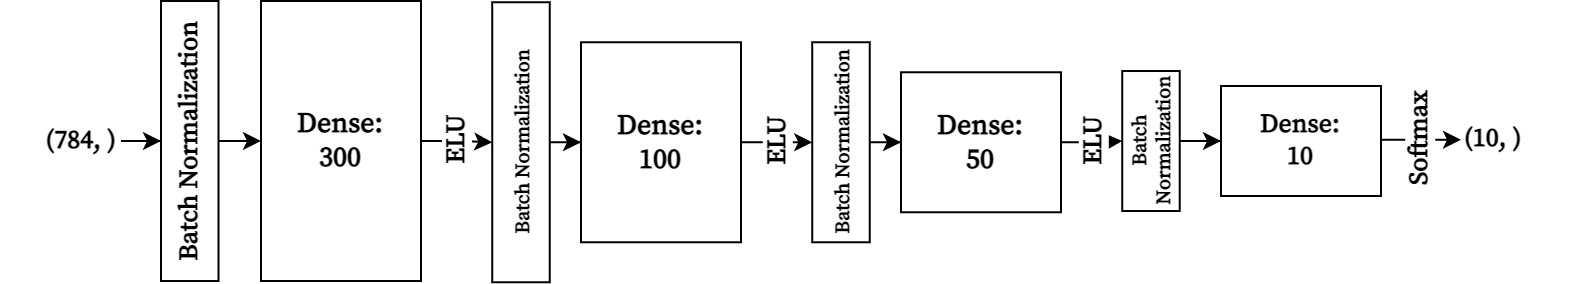

We will use the DNN model that we built in the previous lecture for performance comparisons.


In [14]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        torch.manual_seed(42)
        self.model = nn.Sequential(
            nn.BatchNorm1d(784),
            nn.Linear(784, 300),
            nn.ELU(),
            nn.BatchNorm1d(300),
            nn.Linear(300, 100),
            nn.ELU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 50),
            nn.ELU(),
            nn.BatchNorm1d(50),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

model = DNN().to(device)
print(model)


DNN(
  (model): Sequential(
    (0): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ELU(alpha=1.0)
    (3): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=300, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=100, out_features=50, bias=True)
    (8): ELU(alpha=1.0)
    (9): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=50, out_features=10, bias=True)
    (11): Softmax(dim=1)
  )
)


In [15]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()  # for integer labels (0-9)
optimizer = Adam(model.parameters())

def train(model, loader):
    model.train()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Train for 5 epochs
for epoch in range(5):
    train(model, train_loader)
    print(f"Epoch {epoch+1} completed.")


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.


In [16]:
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

evaluate(model, test_loader)


Test Accuracy: 0.8615


###### Convolution Neural Network

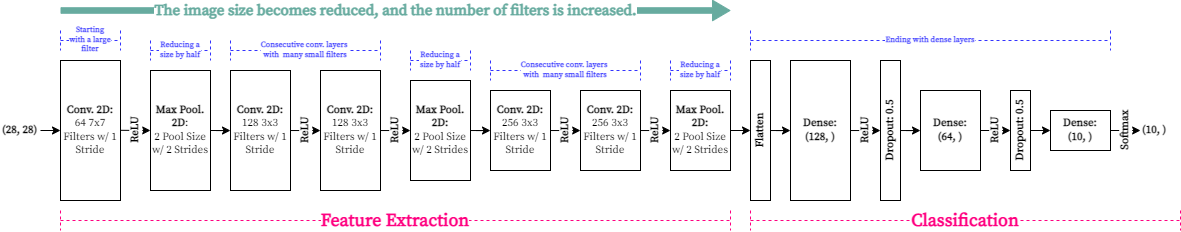

([Here](https://drive.google.com/file/d/15A_d1RWi27WTu9h-cqbnTI1X34z0ZVpI/view?usp=sharing) is the bigger image.)

As shown above, the CNN architecture typically:
* Starts with the small number of filters but the large kernel size
* Reduces the input size using the pooling layer
* Joins multiple convolution layers together
* Increase the number of filters as the input size is reduced and the network goes deeper
* Ends with fully connected layers

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'GPU found: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None"}')

# Set random seed
torch.manual_seed(42)

# He normal initialization
def he_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 7, padding=3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.ReLU(),
            nn.Conv2d(256,256,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(256*3*3,128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128,64),      nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(64,10)        # <--- no Softmax here
        )
        self.net.apply(he_init)

    def forward(self,x):
        return self.net(x)          # logits


model = CNNModel().to(device)
print(model)



GPU found: Tesla T4
CNNModel(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=2304, out_features=128, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): Linear(in_features=128, out_features=64, bias=True)
    (18

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to (1, 28, 28) and scale to [0, 1]
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [19]:
criterion  = nn.CrossEntropyLoss()
optimizer  = Adam(model.parameters())

def train(model, loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            logits   = model(X)
            loss     = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)   # sum of batch losses *batch_size
        epoch_loss = running_loss / len(loader.dataset)  # mean epoch loss
        print(f'Epoch {epoch+1} | Loss: {epoch_loss:.4f}')

train(model, train_loader, criterion, optimizer, epochs=5)

Epoch 1 | Loss: 0.8024
Epoch 2 | Loss: 0.4366
Epoch 3 | Loss: 0.3683
Epoch 4 | Loss: 0.3238
Epoch 5 | Loss: 0.2937


In [20]:
def evaluate_model(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            preds = output.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

evaluate_model(model, test_loader)


Test Accuracy: 0.9010


As you see, CNN's performance is slightly better than the DNN, right?

## Recurrent Neural Network (RNN)

### Background
Neural networks that we have covered predict something only considering current inputs. Although CNN partially considers the temporal relationship between data, it does not genuinely handle a temporal sequence but instead extracts features from sliding windows.
Here, we introduce a particular neural network, a recurrent neural network, which is devised to process sequences. Literally, the recurrent neural network employs a recurrent operation, in which outputs of RNN perceptrons are used as inputs again.

#### Recurrent Layer

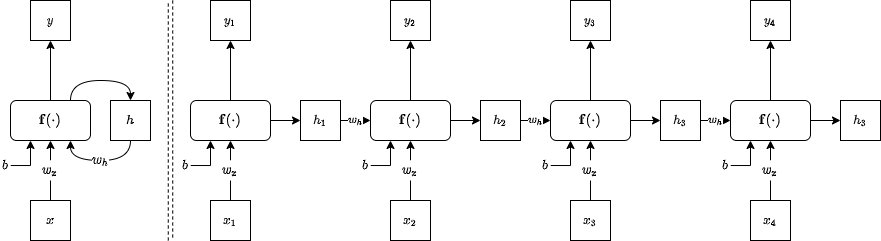

The above figure shows how RNN works. The left is a simple representation of the RNN perceptron (or *memory cell*). First, the cell receives two inputs: a regular input, $x$, and the previous *hidden state*, $h$. Then, it puts out two types of outputs, a regular output, $y$, and *hidden state*, $h$.

If you unroll the left figure, you can understand the structure of the RNN more clearly. At each time step $t$, the cell receives $x_t$ and $h_{t-1}$ and puts out $y_t$ and $h_t$.

Then, let's implement this RNN in pytorch.

In [21]:
import torch
import torch.nn as nn

# SimpleRNN with 1 unit and single feature
class RNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=1,
            batch_first=True
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        return out

model = RNN1()
print(model)

# Dummy input: batch=1, timesteps=5, features=1
x = torch.randn(1, 5, 1)
y = model(x)
print("Output shape:", y.shape)


RNN1(
  (rnn): RNN(1, 1, batch_first=True)
)
Output shape: torch.Size([1, 5, 1])



As shown above, our RNN has three parameters:
* A weight for the input
* A weight for the hidden state
* A bias

What if we consider the larger dimensional inputs with specific time steps and the larger number of cells? Suppose we have 2 RNN cells and 3-D inputs are collected for 4 time steps.

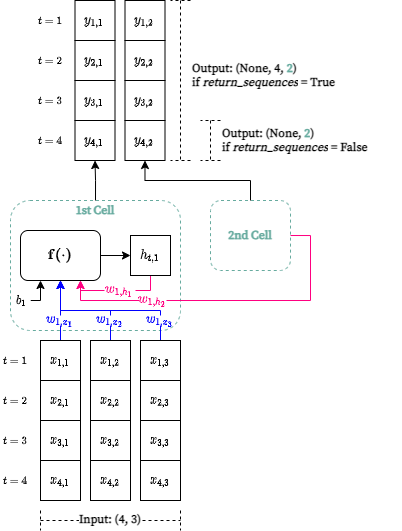

As shown above, this layer puts outs 4-D outputs, in which each RNN cell puts out an output. In addition, each RNN cell receives all inputs and all hidden states.

The important note is that you can choose whether the RNN layer gives outputs as sequences or not using the argument, "return_sequences." If you want a sequence output, the RNN layer gives multiple rows of outputs, in which the number of rows is equal to the input length (or time steps). If not, it provides the last output.

Let's implement this!

In [22]:
class RNN2_LastOutput(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=3,
            hidden_size=2,
            batch_first=True
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        return out[:, -1, :]  # last timestep only

model = RNN2_LastOutput()
print("# return_sequences = False")
print(model)

x = torch.randn(1, 4, 3)  # (batch, time_steps, features)
y = model(x)
print("Output shape:", y.shape)  # (1, 2)


# return_sequences = False
RNN2_LastOutput(
  (rnn): RNN(3, 2, batch_first=True)
)
Output shape: torch.Size([1, 2])


As shown above, both RNN layer have 12 trainable parameters: 2 (# cells) x 8 (3 weights for inputs + 2 weights for hidden states + 1 bias).
In addition, the layer whose *return_sequences = True* gives a sequence output whose length is equal to the input length (i.e., 4).

In PyTorch, nn.RNNCell is used manually — you must loop over time steps yourself:

In [23]:
class RNN2_AllOutputs(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=3,
            hidden_size=2,
            batch_first=True
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        return out

model = RNN2_AllOutputs()
print("# return_sequences = True")
print(model)

x = torch.randn(1, 4, 3)
y = model(x)
print("Output shape:", y.shape)  # (1, 4, 2)


# return_sequences = True
RNN2_AllOutputs(
  (rnn): RNN(3, 2, batch_first=True)
)
Output shape: torch.Size([1, 4, 2])


What are the differences between the two ways of implementing the RNN? While the first is simple and optimized for GPU use, it does not support a customized RNN cell. On the other hand, the second way is slightly cumbersome to write and is not optimized for the GPU. However, we can put a custom RNN cell there (we will show it later).


#### Types of RNN
As you expected in the previous example, the RNN can give different forms of outputs, like a vector vs. a sequence. Here, we will cover a variety of RNNs considering inputs and outputs.

##### Sequence-to-Vector Network

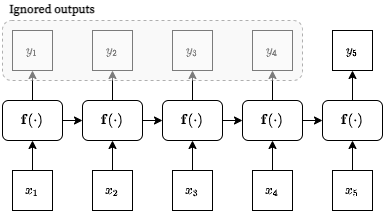

*The sequence-to-vector network* gives a vector output from a sequence input (like, *return_sequences = False*). For example, you could feed the network with a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., -1: hate to +1: love).


##### Sequence-to-Sequence Network

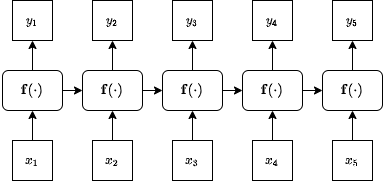

Of course, the RNN can give a sequence output from a sequence input (like, *return_sequences = True*). This network helps predict time series such as stock prices: you feed it with the prices over the last N days, and it outputs the prices shifted by one day into the future.

##### Vector-to-Sequence Network

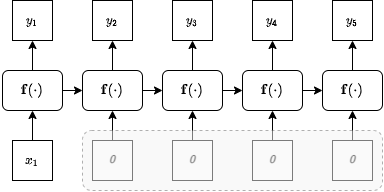

Surprisingly, the RNN can use a vector as input and put out a sequence as output. The representative example is a description of the image: input could be an image, and the output could be a short sentence that describes the image.

##### Encoder-Decoder


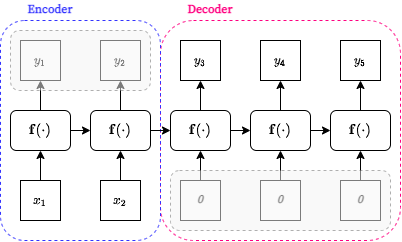

Lastly, you may merge two networks: one is a sequence-to-vector network, called *an encoder*, and the other is a vector-to-sequence network, called  *a  decoder*. For example, this could be used for translating a sentence from one language to another. If you first input a sentence in one language, the encoder converts this sentence into a single vector representation. Then, the decoder would decode this vector into a sentence in another language.

Why do we just translate a sequence of one language into a sequence of another language using the sequence-to-sequence network? Actually, the whole words of a sentence are highly correlated. Therefore, the network needs to wait until the whole sentence comes in for a more correct translation.

#### Problems with Training Long Sequences
As you learned, the RNN is devised to handle sequences. However, the vanilla RNN does not work well, especially in handling long sequences. From now, we will cover the shortcomings of the vanilla RNN and how to complement them.

##### Exploding/Unstable Gradients
As we briefly covered in the previous lecture on the DNN, gradient descent may also malfunction in the RNN. In practice, the gradient often grows larger and larger so that the RNN cannot find the optimal parameter. This phenomenon is called the *exploding gradient*. Why does such a problem occur? Let's see how backpropagation works in the RNN.

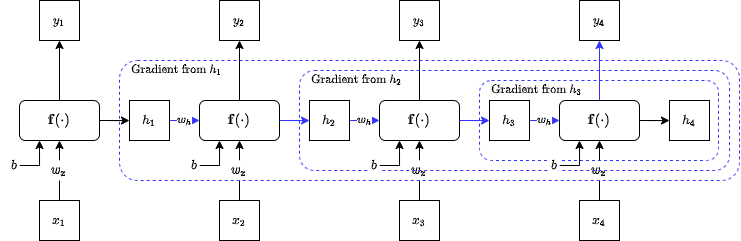

The figure above is an unrolled architecture of the RNN. The regular neural network has several weight parameters corresponding to inputs. However, *the RNN shares parameters*. Therefore, the loss gradient with respect to a given weight is roughly *the sum of all gradients from previous time steps*. As a result, the gradient would be highly likely to grow.

###### Gradient Clipping
Gradient Clipping Methods:

- clip_grad_value_(): Clips the gradients to be within a specific range (between -clip_value and +clip_value)
- clip_grad_norm_(): Clips the gradient norm to a maximum value (commented in the example)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        return self.linear(x)

# Create a complete training workflow demonstrating gradient clipping
def train_with_gradient_clipping():
    # Create a model
    model = SimpleModel()

    # Create some dummy input data and targets
    inputs = torch.randn(5, 10)  # 5 samples, 10 features
    targets = torch.randn(5, 1)  # 5 corresponding targets

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute loss
    loss = criterion(outputs, targets)

    # Backward pass
    loss.backward()

    # Gradient clipping
    # Clip gradient values to be between -1.0 and 1.0
    torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

    # Alternative method: Clip gradient norm
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # Update weights
    optimizer.step()

    print(f"Loss: {loss.item()}")

# Run the training function
train_with_gradient_clipping()


Loss: 3.870614528656006


###### Using Saturating Activating Function
Another technique to prevent exploding gradient is to *use saturating function*. It is surprising, right? While the DNN uses *a non-saturating function* (e.g., Leaky ReLU, SELU, ELU, etc.) for addressing vanishing gradient, the RNN needs to use the saturating function!

|Leaky ReLU|tanh|sigmoid|
|--|--|--|
|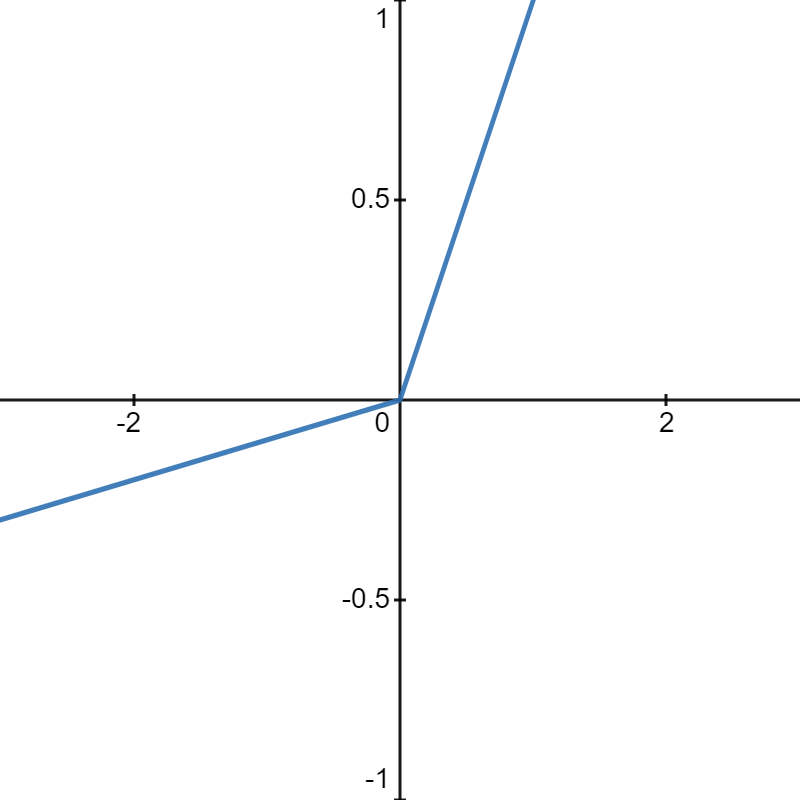|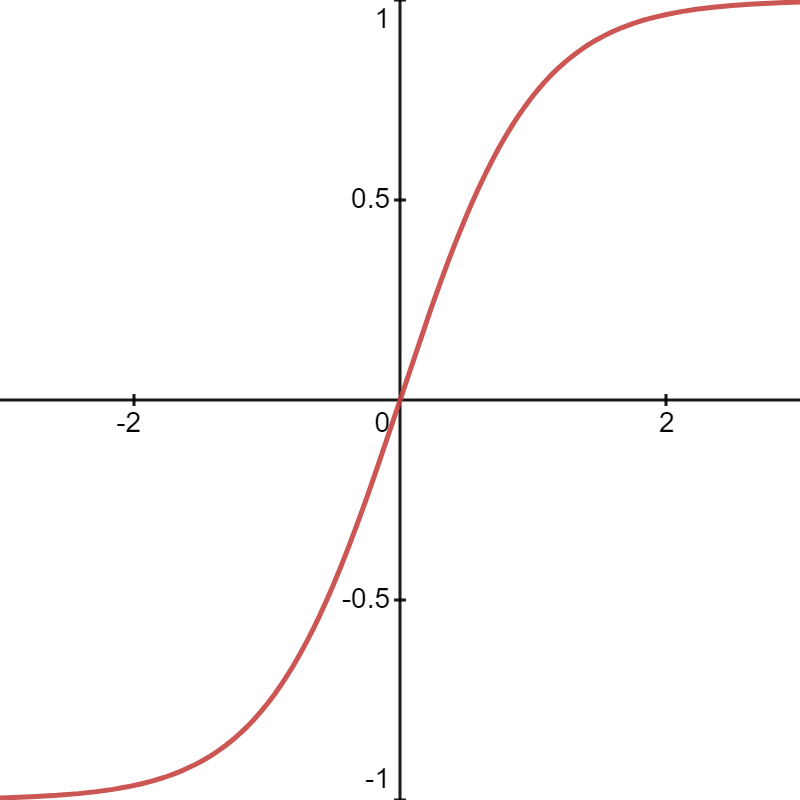|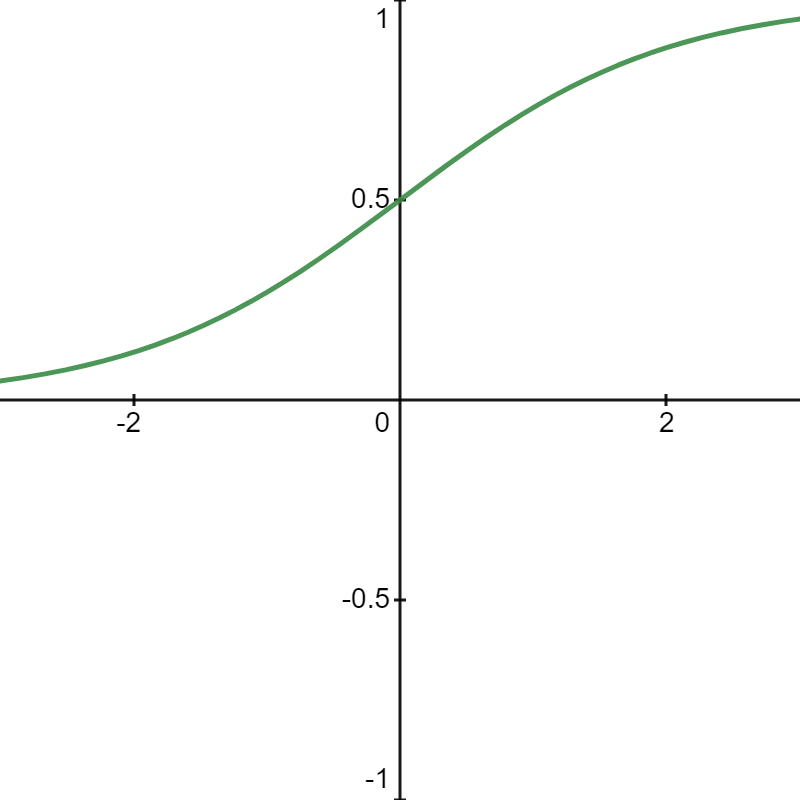|

The theoretical explanation about Leaky ReLU and saturating functions remains valid, as these are universal neural network concepts. Let's look at PyTorch's default RNN implementation:

```python
torch.nn.RNN(
    input_size,  # The number of expected features in the input x
    hidden_size,  # The number of features in the hidden state h
    num_layers=1,  # Number of recurrent layers
    nonlinearity='tanh',  # The non-linearity to use. Can be either 'tanh' or 'relu'
    bias=True,  # If False, then the layer does not use bias weights
    batch_first=False,  # If True, then the input and output tensors are (batch, seq, feature)
    dropout=0.,  # If non-zero, introduces a dropout layer after each RNN layer
    bidirectional=False,  # If True, becomes a bidirectional RNN
)
```

As we can see, PyTorch's RNN also uses hyperbolic tangent (tanh) as the default activation function. This is because:

The tanh function outputs values in the range [-1, 1], which helps prevent gradient explosion
The derivative of tanh near zero is close to 1, which helps maintain stable training
Compared to sigmoid, tanh is zero-centered, making it easier for subsequent layers to learn

For an actual implementation example, here's how you might create and use a simple RNN in PyTorch:

###### Layer Normalization
As we covered in the previous lecture, *batch normalization* normalizes and rescales one batch of inputs to reduce the risk of unstable gradients in the DNN. Is it possible to use batch normalization in the RNN? It may not. As we learned, batch normalization is *the layer that standardizes inputs*. Therefore, if you want to apply batch normalization in the RNN, you have to *put different batch normalization layers between unrolled cells*, as below.

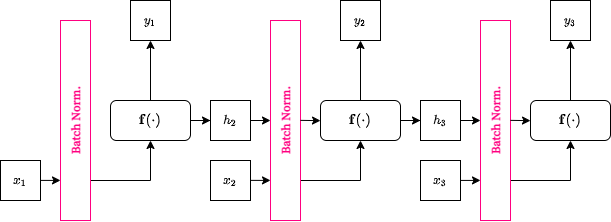

Although it seems complicated to implement, researchers tried it. Unfortunately, [it does not work well](https://arxiv.org/abs/1510.01378). It was found that the batch normalization in the RNN is slightly beneficial only when it was applied to the inputs, not between unrolled cells.

Instead, RNN uses a different type of normalization: *Layer Normalization*. While batch normalization considers a batch of each input (e.g., rows of a single column in tabular data), layer normalization considers the feature dimension (e.g., a single row of columns in tabular data). It seems weird, but actually, it works.

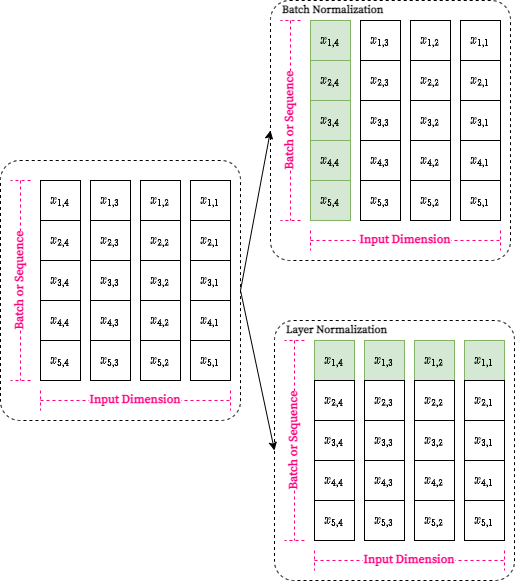

The RNN with the layer normalization works differently from the batch normalization:
$$ h_{\mathbf{w}, b, \gamma, \beta} (\mathbf{x}) = \phi(\gamma \frac{\mathbf{w}^\intercal \mathbf{x} - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta) + b$$
where
* $\phi$: Activation function for the RNN cell
* $ \mu $: Mean of *feature dimension* ($\mathbf{w}^\intercal \mathbf{x}$)
* $ \sigma $: Variance of *feature dimension* ($\mathbf{w}^\intercal \mathbf{x}$)
* $ \gamma $: Rescaling parameter
* $ \beta $: Offset
* $\epsilon$: Hyperparameter for preventing zero-division

While the batch normalization maintains $\mu$ and $\sigma$ to calculate the final mean and variance for test set prediction, the layer normalization calculates these values at each time step. Therefore, it does not need to hold them for training.

Unlike batch normalization, layer normalization calculates μ
and σ at each time step, eliminating the need to maintain running statistics for inference. In PyTorch, we can implement this using built-in modules:

In [25]:
import torch
import torch.nn as nn

class LayerNormRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LayerNormRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Regular RNN parameters
        self.weight_ih = nn.Parameter(torch.randn(hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))

        # Layer normalization components
        self.layer_norm = nn.LayerNorm(hidden_size)

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight_ih)
        nn.init.orthogonal_(self.weight_hh)

    def forward(self, input, hidden):
        # Compute regular RNN pre-activation
        gate_input = torch.mm(input, self.weight_ih.t())
        gate_hidden = torch.mm(hidden, self.weight_hh.t())
        gate_preact = gate_input + gate_hidden + self.bias

        # Apply layer normalization
        normalized = self.layer_norm(gate_preact)

        # Apply activation function
        output = torch.tanh(normalized)

        return output

class LayerNormRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LayerNormRNN, self).__init__()
        self.rnn_cell = LayerNormRNNCell(input_size, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, x, h0=None):
        # x shape: (batch, seq_len, input_size)
        batch_size = x.size(0)
        seq_len = x.size(1)

        if h0 is None:
            h0 = torch.zeros(batch_size, self.hidden_size, device=x.device)

        hidden = h0
        output = []

        # Process sequence
        for t in range(seq_len):
            hidden = self.rnn_cell(x[:, t, :], hidden)
            output.append(hidden)

        # Stack outputs
        output = torch.stack(output, dim=1)
        return output, hidden

# Example usage
input_size = 3
hidden_size = 4
batch_size = 32
seq_length = 10

# Create modelq
model = LayerNormRNN(input_size, hidden_size)

# Create dummy input
x = torch.randn(batch_size, seq_length, input_size)

# Forward pass
output, final_hidden = model(x)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model)}")

Total trainable parameters: 40


In our PyTorch LayerNormRNN:
- weight_ih: hidden_size × input_size = 4 × 3 = 12 parameters
- weight_hh: hidden_size × hidden_size = 4 × 4 = 16 parameters
- bias: hidden_size = 4 parameters
- LayerNorm parameters:
- weight (gamma): hidden_size = 4 parameters
- bias (beta): hidden_size = 4 parameters

Total = 12 + 16 + 4 + 4 + 4 = 40 parameters


##### Vanishing Early Inputs

Another problem of the vanilla RNN for handling long sequences is that it does not contain any trace of early inputs. Suppose we translate very long sentences. When the input sentence ends, the RNN may forget what the first word is. We need to remember something that informs the network of how the sentence is started. In other words, we want to allow the RNN to have *a long-term memory*. The representative technique for the long-term memory cell is the *Long Short-Term Memory (LSTM)*.

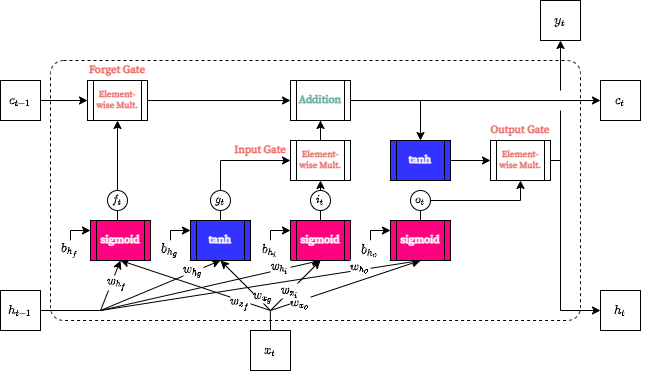

The figure above shows the architecture of the LSTM cell. It looks pretty complicated. Don't worry. We will not cover all details of the LSTM because this course is not deep learning. Instead, we will briefly look over the main ideas of the LSTM cell.
As shown above, the LSTM has two hidden states: the long-term state, $c_t$, and the short-term state, $h_t$. The long-term state, $c_t$, first goes through a forget gate to drop some memories. Then, new memories (i.e., inputs, $x_t$, and the short-term state, $h_t$) from input gate are added to the $c_t$.
On the other hand, the short-term state, $h_t$, goes through an output gate, building the new short-term state, which is composed of the new long-term state, the previous short-term state, and the new inputs. The output of the LSTM state is equal to the new short-term state.

In [26]:
import torch
import torch.nn as nn

# Define a simple LSTM model
model = nn.Sequential(
    nn.LSTM(
        input_size=3,     # Dimension of input features
        hidden_size=4,    # Number of LSTM units
        batch_first=True  # Input shape: (batch_size, seq_len, features)
    )
)

# Print model information
print(model)

# Let's check the parameter count
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

# Example input to visualize dimensions
example_input = torch.randn(1, 4, 3)  # (batch_size, seq_length, input_features)
output, (hidden_state, cell_state) = model(example_input)

print(f"Output shape: {output.shape}")
print(f"Hidden state shape: {hidden_state.shape}")
print(f"Cell state shape: {cell_state.shape}")

Sequential(
  (0): LSTM(3, 4, batch_first=True)
)
Total parameters: 144
Output shape: torch.Size([1, 4, 4])
Hidden state shape: torch.Size([1, 1, 4])
Cell state shape: torch.Size([1, 1, 4])


Alternatively, you can use nn.LSTMCell to have more control over the LSTM computation:

In [27]:
import torch
import torch.nn as nn

# Define a model using LSTMCell
class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=4):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        batch_size, seq_len, _ = x.size()

        # Initialize hidden state and cell state
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # List to store outputs
        outputs = []

        # Process each time step
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], (h_t, c_t))
            outputs.append(h_t)

        # Stack outputs along sequence dimension
        outputs = torch.stack(outputs, dim=1)

        return outputs, (h_t, c_t)

# Create the model
model = LSTMModel(input_size=3, hidden_size=4)

# Print model information
print(model)

# Check parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

# Example input
example_input = torch.randn(1, 4, 3)  # (batch_size, seq_length, input_features)
output, (final_h, final_c) = model(example_input)

print(f"Output shape: {output.shape}")
print(f"Final hidden state shape: {final_h.shape}")
print(f"Final cell state shape: {final_c.shape}")

LSTMModel(
  (lstm_cell): LSTMCell(3, 4)
)
Total parameters: 144
Output shape: torch.Size([1, 4, 4])
Final hidden state shape: torch.Size([1, 4])
Final cell state shape: torch.Size([1, 4])


We have 128 parameters that need to be optimized: 4 (# cells) × 32 (4 weights for the input × 3-D input + 4 weights for the short-term state × 4 perceptrons + 4 biases)

In [28]:
import torch
import torch.nn as nn

# Define a model using LSTMCell
class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=4):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        batch_size, seq_len, _ = x.size()

        # Initialize hidden state and cell state
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # List to store outputs
        outputs = []

        # Process each time step
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], (h_t, c_t))
            outputs.append(h_t)

        # Stack outputs along sequence dimension
        outputs = torch.stack(outputs, dim=1)

        return outputs, (h_t, c_t)

# Create the model
model = LSTMModel(input_size=3, hidden_size=4)

# Print model information
print(model)

# Check parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

# Example input
example_input = torch.randn(1, 4, 3)  # (batch_size, seq_length, input_features)
output, (final_h, final_c) = model(example_input)

print(f"Output shape: {output.shape}")
print(f"Final hidden state shape: {final_h.shape}")
print(f"Final cell state shape: {final_c.shape}")

LSTMModel(
  (lstm_cell): LSTMCell(3, 4)
)
Total parameters: 144
Output shape: torch.Size([1, 4, 4])
Final hidden state shape: torch.Size([1, 4])
Final cell state shape: torch.Size([1, 4])


To implement the layer normalization in LSTM, we need to create a custom layer-normalized LSTM cell. PyTorch doesn't have a built-in layer-normalized LSTM like TensorFlow Addons, so we'll implement it:

In [29]:
import torch
import torch.nn as nn

class LayerNormLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LayerNormLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM weights
        self.weight_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(4 * hidden_size))

        # Layer normalization components
        # One for each gate and one for cell state
        self.ln_i2h = nn.LayerNorm(4 * hidden_size)
        self.ln_h2h = nn.LayerNorm(4 * hidden_size)
        self.ln_c = nn.LayerNorm(hidden_size)

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight_ih)
        nn.init.xavier_uniform_(self.weight_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)

    def forward(self, x, hidden):
        # x: input tensor of shape (batch_size, input_size)
        # hidden: tuple of (h, c) each with shape (batch_size, hidden_size)
        h, c = hidden

        # Calculate gates with layer normalization
        i2h = self.ln_i2h(torch.mm(x, self.weight_ih.t()) + self.bias_ih)
        h2h = self.ln_h2h(torch.mm(h, self.weight_hh.t()) + self.bias_hh)
        gates = i2h + h2h

        # Split gates
        gates_chunks = gates.chunk(4, 1)

        # Extract gates
        i = torch.sigmoid(gates_chunks[0])  # input gate
        f = torch.sigmoid(gates_chunks[1])  # forget gate
        g = torch.tanh(gates_chunks[2])     # cell gate
        o = torch.sigmoid(gates_chunks[3])  # output gate

        # Update cell state with layer normalization
        c_next = f * c + i * g
        c_next_normalized = self.ln_c(c_next)

        # Update hidden state
        h_next = o * torch.tanh(c_next_normalized)

        return h_next, c_next

class LayerNormLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LayerNormLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.cell = LayerNormLSTMCell(input_size, hidden_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        batch_size, seq_len, _ = x.size()

        # Initialize hidden and cell states
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Store outputs
        outputs = []

        # Process each time step
        for t in range(seq_len):
            h_t, c_t = self.cell(x[:, t, :], (h_t, c_t))
            outputs.append(h_t)

        # Stack outputs along sequence dimension
        outputs = torch.stack(outputs, dim=1)

        return outputs, (h_t, c_t)

# Create the layer-normalized LSTM model
ln_lstm_model = LayerNormLSTM(input_size=3, hidden_size=4)

# Print model information
print(ln_lstm_model)

# Count parameters
total_params = sum(p.numel() for p in ln_lstm_model.parameters())
print(f"Total parameters: {total_params}")

# Example input
example_input = torch.randn(1, 4, 3)  # (batch_size, seq_length, input_features)
output, (final_h, final_c) = ln_lstm_model(example_input)

print(f"Output shape: {output.shape}")
print(f"Final hidden state shape: {final_h.shape}")
print(f"Final cell state shape: {final_c.shape}")

LayerNormLSTM(
  (cell): LayerNormLSTMCell(
    (ln_i2h): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (ln_h2h): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (ln_c): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  )
)
Total parameters: 216
Output shape: torch.Size([1, 4, 4])
Final hidden state shape: torch.Size([1, 4])
Final cell state shape: torch.Size([1, 4])


In the layer-normalized LSTM, we have additional parameters for the normalization layers. For each of the 9 components (i2h for 4 gates, h2h for 4 gates, and the cell state), we have both γ (scale) and β (shift) parameters, totaling to additional normalization parameters beyond the standard LSTM weights.

## Practice: Classifying Different Physical Activities using CNN and RNN

That's all for theory. Now, we will build actual CNN and RNN models.

### Data: UCI's Smartphone-Based Recognition of Human Activities and Postural Transitions (HAPT) Data Set


HAPT dataset is built from the sensor recordings of 30 subjects who perform basic physical activities. The activities are:
* Static postures: standing, sitting, lying
* Dynamic activities: walking, walking downstairs, and walking upstairs.
* Transition: stand-to-sit, sit-to-stand, sit-to-lie, lie-to-sit, stand-to-lie, and lie-to-stand.

All the participants wore a smartphone (Samsung Galaxy S II) on their waist. 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz using the embedded accelerometer and gyroscope of the device.

The video below shows the data collection setting.

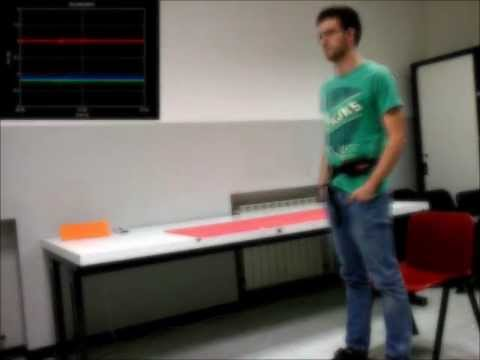

In [30]:
from IPython.display import YouTubeVideo
YouTubeVideo('XOEN9W05_4A', width=1000, height=800)

In [31]:
from urllib.request import urlopen
import pickle
import numpy as np


URL = 'https://drive.google.com/uc?export=download&id=15mVbcvxP2-Lhs9H-ayOclftHWxp8lIyo'

DATASET = pickle.load(urlopen(URL))

X = DATASET['X']
y = DATASET['y']
PIDS = DATASET['pid']
LABELS = DATASET['labels']
COLUMNS = DATASET["columns"]


print(f'Columns: {COLUMNS}')
print(f'Data shape: X={X.shape}; y={y.shape}; pid={PIDS.shape}')
print(f'Label: \r\n{LABELS}')
print(f'Label dist.: \r\n{np.unique(y, return_counts=True)}')

Columns: ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
Data shape: X=(1122772, 6); y=(1122772,); pid=(1122772,)
Label: 
{12.0: 'UNLABELED', 0.0: 'WALKING', 1.0: 'WALKING_UPSTAIRS', 2.0: 'WALKING_DOWNSTAIRS', 3.0: 'SITTING', 4.0: 'STANDING', 5.0: 'LAYING', 6.0: 'STAND_TO_SIT', 7.0: 'SIT_TO_STAND', 8.0: 'SIT_TO_LIE', 9.0: 'LIE_TO_SIT', 10.0: 'STAND_TO_LIE', 11.0: 'LIE_TO_STAND'}
Label dist.: 
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([122091, 116707, 107961, 126677, 138105, 136865,  10316,   8029,
        12428,  11150,  14418,  10867, 307158]))


Let's visualize this data for participant #1.

In [32]:
from itertools import product
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


fig = make_subplots(
    rows=6, cols=1, shared_xaxes=True, shared_yaxes=False,
    row_titles=COLUMNS
)

M_p1 = PIDS == 1
X_p1 = X[M_p1]
y_p1 = y[M_p1]
t = np.arange(X_p1.shape[0])

for i, c in enumerate(COLUMNS):
    for j in np.unique(y_p1):
        label = LABELS[j]
        M_t = y_p1 == j
        t_j = t[M_t]
        x = X_p1[M_t, i]

        fig.add_trace(
            go.Scatter(x=t_j, y=x, mode='markers', name=label, showlegend=False, marker=dict(size=2)),
            row=(i+1), col=1,
        )

fig.update_layout(
    width=1000,
    height=1000
)

fig.show()


As shown in the plots above, 3-axial sensor data clearly shows directional characteristics of physical activities. However, we want other data that show trends independent of the direction. For this, we put additional data, *the magnitude of 3-axial values*, into the original data:
$$ \text{magnitude} = \sqrt{x^2 + y^2 + z^2} $$

In [33]:
import numpy as np

X_w_mag = np.concatenate(
    (
        # Original data
        X,
        # Mag. of 3-axial acceleration values
        np.sqrt(np.sum(np.square(X[:, 0:3]), axis=1)).reshape(-1, 1),
        # Mag. of 3-axial gyroscope values
        np.sqrt(np.sum(np.square(X[:, 3:6]), axis=1)).reshape(-1, 1)
    ), axis=1
)

X_w_mag.shape

(1122772, 8)

### Preparation: 2-D Vector Input to 3-D Vector Input

Because human beings' physical activities are performed over time, we cannot predict them using a single shot of sensor data. Instead, we will predict activities using a window of inputs across several time steps. For example, suppose we want to build a model that classifies physical activities every 1 second using 2-seconds data (i.e., a 2-second time window with a 1-second slide). Then, each window contains *100 (2-second x 50Hz) samples* with sliding by 50 samples (1-second x 50Hz), in which each sample has 8 values (3-axial accelerometer/gyroscope and their magnitudes).

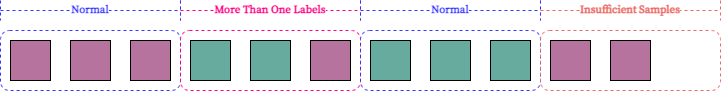


Unfortunately, if we divide the entire data into 2-second windows, there may exist *some boundary windows where two or more activities are performed*. In addition, *some windows may have samples smaller than 100*. We will exclude such data. Moreover, in this practice, we focus on *physical activity labels (i.e., standing, sitting, lying, walking, walking downstairs, and walking upstairs)*, not transition.


In [34]:
import numpy as np
import torch

# Constants
WIN_SIZE = 100  # window size: 2 seconds at 50Hz
SLIDE = 50      # stride: 1 second at 50Hz

# Convert to PyTorch Tensor
X_tensor = torch.tensor(X_w_mag, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
pid_tensor = torch.tensor(PIDS, dtype=torch.long)

# Collect windowed samples
X_windows = []
y_windows = []
pid_windows = []

# Loop through data per participant
for pid in torch.unique(pid_tensor):
    # Get data for current participant
    mask = pid_tensor == pid
    X_pid = X_tensor[mask]
    y_pid = y_tensor[mask]

    # Apply sliding window
    for start in range(0, len(X_pid) - WIN_SIZE + 1, SLIDE):
        end = start + WIN_SIZE
        window = X_pid[start:end]
        label = torch.mode(y_pid[start:end])[0]  # most frequent label in window

        if window.shape[0] == WIN_SIZE:
            X_windows.append(window)
            y_windows.append(label)
            pid_windows.append(pid)

# Stack all windows into final tensors
X_windows = torch.stack(X_windows)  # Shape: [N_windows, WIN_SIZE, N_features]
y_windows = torch.stack(y_windows)  # Shape: [N_windows]
pid_windows = torch.stack(pid_windows)  # Shape: [N_windows]

# Print final shapes
print(f'Windowed data shape: X={X_windows.shape}; y={y_windows.shape}; pid={pid_windows.shape}')


Windowed data shape: X=torch.Size([22411, 100, 8]); y=torch.Size([22411]); pid=torch.Size([22411])


In [35]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Create a TensorDataset
dataset = TensorDataset(X_windows, y_windows)

# Optionally, split into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [36]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=64, num_layers=1, num_classes=6):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_size]
        out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])  # Use the last hidden state
        return out


In [37]:
print("Labels min:", y_windows.min().item(), "max:", y_windows.max().item())
print("Unique labels:", torch.unique(y_windows))


Labels min: 0 max: 12
Unique labels: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])


In [38]:
model = LSTMModel(input_size=8, num_classes=13).to(device)
model.eval()

# Try single input
X_sample = X_windows[0:1].to(device)  # shape should be [1, 100, 8]

with torch.no_grad():
    output = model(X_sample)
    print("Output shape:", output.shape)


Output shape: torch.Size([1, 13])


In [39]:
import torch.optim as optim

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
NUM_CLASSES = len(torch.unique(y_windows))
model = LSTMModel(num_classes=NUM_CLASSES).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 1.7481
Epoch [2/10], Loss: 1.5140
Epoch [3/10], Loss: 1.5256
Epoch [4/10], Loss: 1.3574
Epoch [5/10], Loss: 1.2740
Epoch [6/10], Loss: 1.2632
Epoch [7/10], Loss: 1.1881
Epoch [8/10], Loss: 1.1137
Epoch [9/10], Loss: 1.0351
Epoch [10/10], Loss: 0.9823


In [40]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 65.42%


### Building and Training

#### Convolution Neural Network

First, we will build the CNN as below:

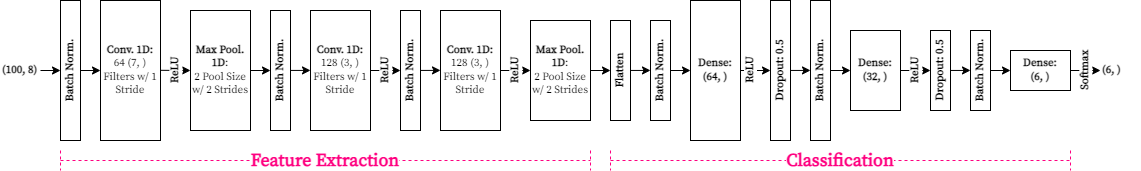

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=13):
        super(CNNModel, self).__init__()
        self.batchnorm0 = nn.BatchNorm1d(num_features=8)  # Input: (batch, 8, 100)

        self.conv1 = nn.Conv1d(in_channels=8, out_channels=64, kernel_size=7, padding=3)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten_dim = 128 * 25  # 100 -> /2 -> 50 -> /2 -> 25

        self.bn3 = nn.BatchNorm1d(self.flatten_dim)
        self.fc1 = nn.Linear(self.flatten_dim, 64)
        self.dropout1 = nn.Dropout(p=0.5)

        self.bn4 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(p=0.5)

        self.bn5 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, num_classes)

        # Initialization
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # He Normal
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: (batch_size, seq_len, feature_dim) => (batch_size, feature_dim, seq_len)
        x = x.permute(0, 2, 1)  # required for Conv1d

        x = self.batchnorm0(x)

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)

        x = F.relu(self.conv2(x))
        x = self.bn2(x)

        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # flatten
        x = self.bn3(x)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.bn4(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.bn5(x)

        x = self.fc3(x)  # logits, no softmax
        return x


In [42]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(X_windows, y_windows)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(num_classes=13).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [44]:
NUM_EPOCHS = 25

best_acc = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_cnn_model.pt")
        print("✅ Saved new best model.")


Epoch 1/25 | Loss: 1.5290 | Train Acc: 53.93% | Val Acc: 81.46%
✅ Saved new best model.
Epoch 2/25 | Loss: 0.9707 | Train Acc: 70.52% | Val Acc: 81.82%
✅ Saved new best model.
Epoch 3/25 | Loss: 0.8198 | Train Acc: 73.86% | Val Acc: 83.85%
✅ Saved new best model.
Epoch 4/25 | Loss: 0.7583 | Train Acc: 75.40% | Val Acc: 84.05%
✅ Saved new best model.
Epoch 5/25 | Loss: 0.7171 | Train Acc: 76.88% | Val Acc: 84.27%
✅ Saved new best model.
Epoch 6/25 | Loss: 0.6633 | Train Acc: 78.24% | Val Acc: 85.50%
✅ Saved new best model.
Epoch 7/25 | Loss: 0.6374 | Train Acc: 79.24% | Val Acc: 85.01%
Epoch 8/25 | Loss: 0.6284 | Train Acc: 79.27% | Val Acc: 84.83%
Epoch 9/25 | Loss: 0.6086 | Train Acc: 79.70% | Val Acc: 83.96%
Epoch 10/25 | Loss: 0.5776 | Train Acc: 80.98% | Val Acc: 84.70%
Epoch 11/25 | Loss: 0.6502 | Train Acc: 78.64% | Val Acc: 85.32%
Epoch 12/25 | Loss: 0.6092 | Train Acc: 80.10% | Val Acc: 85.81%
✅ Saved new best model.
Epoch 13/25 | Loss: 0.5815 | Train Acc: 80.47% | Val Acc: 86.

In [45]:
# Load best model
model.load_state_dict(torch.load("best_cnn_model.pt"))
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()

print(f"🎯 Final Test Accuracy: {100 * test_correct / test_total:.2f}%")


🎯 Final Test Accuracy: 87.06%


#### Long Short-Term Memory
Of course, we will also build the LSTM.

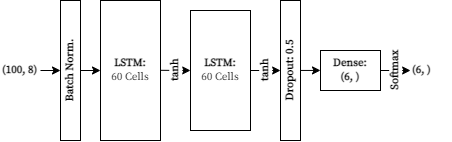

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMNet(nn.Module):
    def __init__(self, input_size=8, hidden_size=60, num_classes=13):
        super(LSTMNet, self).__init__()

        self.batchnorm = nn.BatchNorm1d(input_size)

        self.lstm1 = nn.LSTM(input_size=input_size,
                             hidden_size=hidden_size,
                             batch_first=True,
                             bidirectional=False)

        self.lstm2 = nn.LSTM(input_size=hidden_size,
                             hidden_size=hidden_size,
                             batch_first=True,
                             bidirectional=False)

        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

        # Apply Xavier (Glorot) Initialization
        nn.init.xavier_normal_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_size]
        x = x.permute(0, 2, 1)  # to [batch, feature, seq] for BatchNorm1d
        x = self.batchnorm(x)
        x = x.permute(0, 2, 1)  # back to [batch, seq, feature] for LSTM

        out1, _ = self.lstm1(x)           # out1: [batch, seq, hidden]
        out2, _ = self.lstm2(out1)        # out2: [batch, seq, hidden]

        last_output = out2[:, -1, :]      # use last time step
        out = self.dropout(last_output)
        out = self.fc(out)                # logits (no softmax for CrossEntropyLoss)
        return out


In [47]:
model = LSTMNet(input_size=8, hidden_size=60, num_classes=13).to(device)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
NUM_EPOCHS = 25

best_acc = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_lstm_model.pt")
        print("✅ Saved new best model.")


Epoch 1/25 | Loss: 1.5094 | Train Acc: 46.23% | Val Acc: 64.35%
✅ Saved new best model.
Epoch 2/25 | Loss: 0.9962 | Train Acc: 68.49% | Val Acc: 73.46%
✅ Saved new best model.
Epoch 3/25 | Loss: 0.8356 | Train Acc: 73.53% | Val Acc: 77.05%
✅ Saved new best model.
Epoch 4/25 | Loss: 0.7721 | Train Acc: 75.43% | Val Acc: 75.46%
Epoch 5/25 | Loss: 0.7178 | Train Acc: 75.83% | Val Acc: 78.56%
✅ Saved new best model.
Epoch 6/25 | Loss: 0.8209 | Train Acc: 72.03% | Val Acc: 79.54%
✅ Saved new best model.
Epoch 7/25 | Loss: 0.6887 | Train Acc: 76.68% | Val Acc: 80.46%
✅ Saved new best model.
Epoch 8/25 | Loss: 0.6223 | Train Acc: 79.12% | Val Acc: 83.34%
✅ Saved new best model.
Epoch 9/25 | Loss: 0.5969 | Train Acc: 79.89% | Val Acc: 80.26%
Epoch 10/25 | Loss: 0.5753 | Train Acc: 80.73% | Val Acc: 83.45%
✅ Saved new best model.
Epoch 11/25 | Loss: 0.5439 | Train Acc: 81.34% | Val Acc: 82.38%
Epoch 12/25 | Loss: 0.5376 | Train Acc: 81.18% | Val Acc: 84.68%
✅ Saved new best model.
Epoch 13/25 |

In [50]:
model.load_state_dict(torch.load("best_lstm_model.pt"))
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()

print(f"🎯 Final Test Accuracy: {100 * test_correct / test_total:.2f}%")

🎯 Final Test Accuracy: 86.48%


#### Convolution + LSTM
Wait, what if we connect the convolution layers and LSTM layers? We may let the convolution layer extract features and the LSTM do classification. Let's merge the two networks we previously built.

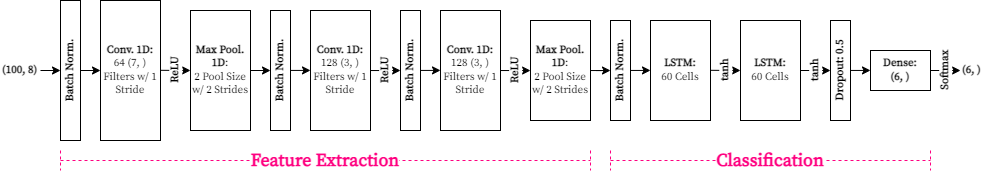

Using device: cuda
Model architecture:
ConvLSTMModel(
  (conv_block1): Sequential(
    (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(8, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lstm1): LSTM(128, 60, batch_first=True)
  (lstm2): LSTM(60, 60

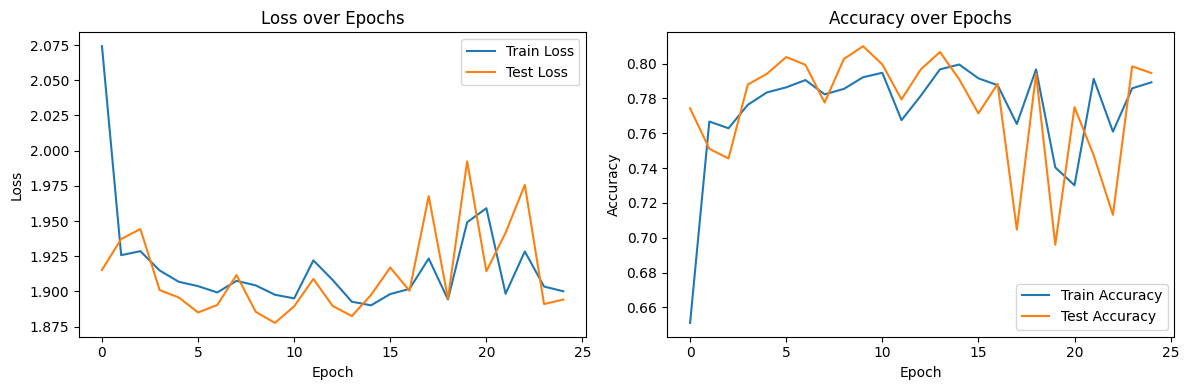

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the ConvLSTM model in PyTorch
class ConvLSTMModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=60, num_classes=13):
        super(ConvLSTMModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        # Convolutional layers with batch normalization and pooling
        self.conv_block1 = nn.Sequential(
            nn.BatchNorm1d(input_size),  # Input shape: (batch_size, input_size, seq_length)
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.BatchNorm1d(64)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.BatchNorm1d(128)
        )

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)

        # Final classification layer
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        # He initialization for Conv layers
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            # Xavier/Glorot initialization for Linear and LSTM layers
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param)

    def forward(self, x):
        # PyTorch uses channels first format (batch_size, channels, seq_length)
        # Input shape: (batch_size, seq_length, features)
        # Need to transpose to (batch_size, features, seq_length)
        x = x.transpose(1, 2)  # Now: (batch_size, input_size, seq_length)

        # Apply convolutional blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # Prepare for LSTM (convert back to batch_size, seq_length, channels)
        x = x.transpose(1, 2)

        # Apply LSTM layers
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        # Take only the last time step output
        x = x[:, -1, :]

        # Apply dropout
        x = self.dropout(x)

        # Final classification
        x = self.fc(x)
        x = self.softmax(x)

        return x

# Load and prepare data (using your provided code)
# Assuming X_windows and y_windows are already prepared tensors
from torch.utils.data import TensorDataset, DataLoader, random_split

# Convert numpy arrays to PyTorch tensors if they aren't already
if not isinstance(X_windows, torch.Tensor):
    X_windows = torch.FloatTensor(X_windows)
if not isinstance(y_windows, torch.Tensor):
    y_windows = torch.LongTensor(y_windows)

# Create dataset and split into train/test
dataset = TensorDataset(X_windows, y_windows)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model and move it to the device
model = ConvLSTMModel(input_size=8, hidden_size=60, num_classes=13).to(device)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model architecture:\n{model}")
print(f"Trainable parameters: {count_parameters(model)}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25):
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = train_loss / train_total
        epoch_train_acc = train_correct / train_total
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / test_total
        epoch_test_acc = test_correct / test_total
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc)

        # Print epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.4f} | '
              f'Train Acc: {epoch_train_acc:.4f} | '
              f'Test Loss: {epoch_test_loss:.4f} | '
              f'Test Acc: {epoch_test_acc:.4f}')

    return model, history

# Train the model
model, history = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25)

# Save the trained model
torch.save(model.state_dict(), 'convlstm_model.pth')

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = sum(p == l for p, l in zip(all_predictions, all_labels)) / len(all_labels)
    print(f"Test Accuracy: {accuracy:.4f}")

    return all_predictions, all_labels

# Evaluate the model
predictions, true_labels = evaluate_model(model, test_loader)

# Optional: Plot training history
try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['test_acc'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib not available for plotting. Install it with 'pip install matplotlib'")

## Homework: Classifying Physical Activities using Different Dataset

In HAPT dataset, sensor data are collected from a waist-mounted smartphone. In this homework, we will use sensor data that are collected in a slightly different setting: the smartphone is in the trousers' front pocket.


### Dataset: [MotionSense](https://www.kaggle.com/datasets/malekzadeh/motionsense-dataset)
Mohammad Malekzadeh, Richard G. Clegg, Andrea Cavallaro, and Hamed Haddadi. 2018. Protecting Sensory Data against Sensitive Inferences. In Proceedings of the 1st Workshop on Privacy by Design in Distributed Systems (W-P2DS'18). Association for Computing Machinery, New York, NY, USA, Article 2, 1–6. https://doi.org/10.1145/3195258.3195260

This dataset includes time-series data generated by *accelerometer and gyroscope sensors (attitude, gravity, userAcceleration, and rotationRate) at 50Hz* and participants' characteristics (e.g., weight, age, etc.) It is collected with an iPhone 6s kept in the participant's front pocket using SensingKit, which collects information from Core Motion framework on iOS devices.

Originally, 24 participants performed 6 activities: *downstairs, upstairs, walking, jogging, sitting, and standing*. However, we will cover only 10 participants for this homework due to size issues.


In [52]:
from urllib.request import urlopen
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

URL = 'https://drive.google.com/uc?export=download&id=16GnTmuktaJy20_a12giTVB7smsjALQNH'

DATASET = pickle.load(urlopen(URL))

X = DATASET['X']
y = DATASET['y']
PIDS = DATASET['pid']
LABELS = DATASET['labels']
COLUMNS = DATASET["columns"]

print(f'Columns: {COLUMNS}')
print(f'Data shape: X={X.shape}; y={y.shape}; pid={PIDS.shape}')
print(f'Label: \r\n{LABELS}')
print(f'Label dist.: \r\n{np.unique(y, return_counts=True)}')
print(f'Participant.: \r\n{np.unique(PIDS)}')

Columns: ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 'weight', 'height', 'age', 'gender']
Data shape: X=(591816, 16); y=(591816,); pid=(591816,)
Label: 
{0.0: 'Downstairs', 1.0: 'Upstairs', 2.0: 'Walking', 3.0: 'Jogging', 4.0: 'Standing', 5.0: 'Sitting'}
Label dist.: 
(array([0., 1., 2., 3., 4., 5.]), array([ 56182,  65447, 144456,  57492, 120458, 147781]))
Participant.: 
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


### Instruction
* You will receive 3 points in total.
* Prepare data
    * Add magnitude values for 3-axial sensor data
        * attitude.role/pitch/yaw
        * gravity.x/y/z
        * rotationRate.x/y/z
        * userAcceleration.x/y/z
    * Exclude time-invariant data, *weight, height, age, gender*.
    * Our network will receive sensor recordings within a 1-second time window, in which the window slides by 0.5-second.
    * Each window should correspond to only one label and contain 50 samples.
* Build the ConvLSTM model as shown below.
    * Use the best weight intialization for each activation function
    * Use the logistic loss for the loss function
    * Use the Nadam optimizer and limit gradients within [-1.0, 1.0]
* Evaluate your model using leave-one-user-out cross-validation.
    * Measure the performance with cross-entropy and accuracy.
* You don't have to do learning rate scheduling and regularization.


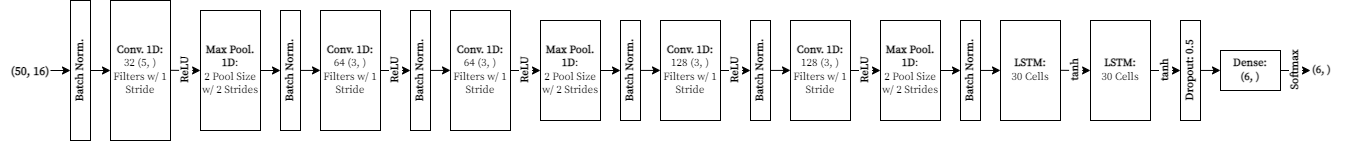

([Here](https://drive.google.com/file/d/16r4d2CGrTlqxCu5qeBWTpoP82CKH46Gs/view?usp=sharing) is the bigger size of the figure above)



### Submission



*   The example code is for your reference and you can modify as you want to meet the homework requirement.



In [66]:
# TODO: refine and improve look at the original instructions
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, log_loss
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from plotly.subplots import make_subplots

# Ensure that the following variables are defined or loaded as needed:
# COLUMNS, X, y, PIDS

METRICS = []

'''------ Begin: Add Magnitude Values for 3-Axial Data (0.25 pt) ------'''
sensor_types = ["attitude", "gravity", "rotationRate", "userAcceleration"]
X_mag = np.copy(X)

for sensor in sensor_types:
    idx = [i for i, col in enumerate(COLUMNS) if col.startswith(sensor)]
    mag = np.sqrt(np.sum(X[:, idx]**2, axis=1)).reshape(-1, 1)
    X_mag = np.hstack((X_mag, mag))
    COLUMNS.append(f"{sensor}_mag")

X = X_mag
'''------ End: Add Magnitude Values for 3-Axial Data (0.25 pt) ------'''

'''------ Begin: Exclude Time-Invariant Data (0.25 pt) ------'''
# Assuming time-invariant columns are 'weight', 'height', 'age', 'gender'
time_invariant_cols = ['weight', 'height', 'age', 'gender']
mask = [col not in time_invariant_cols for col in COLUMNS]

X = X[:, mask]
COLUMNS = [col for i, col in enumerate(COLUMNS) if mask[i]]
'''------ End: Exclude Time-Invariant Data (0.25 pt) ------'''

'''------ Begin: Preprocess Data (0.5 pt) ------'''
window_size = 50
stride = 25

X_prep, y_prep, PIDS_prep = [], [], []
for i in range(0, X.shape[0] - window_size + 1, stride):
    window_X = X[i:i + window_size]
    window_y = y[i:i + window_size]
    window_pid = PIDS[i:i + window_size]

    if len(np.unique(window_y)) == 1 and len(window_X) == window_size:
        X_prep.append(window_X)
        y_prep.append(window_y[0])
        PIDS_prep.append(window_pid[0])

X_prep = np.array(X_prep)
y_prep = np.array(y_prep)
PIDS_prep = np.array(PIDS_prep)

print("X_prep shape:", X_prep.shape)
print("y_prep shape:", y_prep.shape)
print("PIDS_prep shape:", PIDS_prep.shape)
'''------ End: Preprocess Data (0.5 pt) ------'''

'''------ Begin: Leave-One-User-Out CV (0.25 pt) ------'''
def is_one_hot(y):
    if y.ndim == 2 and np.all(np.isin(y, [0, 1])):  # Only 0s and 1s
        # Check if each row has exactly one "1" (meaning it's one-hot)
        return np.all(y.sum(axis=1) == 1)
    return False

if is_one_hot(y_prep):
    y_classes = np.argmax(y_prep, axis=1)

else:
    y_classes = y_prep

'''------ End: Leave-One-User-Out CV (0.25 pt) ------'''

# Configure device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the PyTorch ConvLSTM model
class ConvLSTMModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ConvLSTMModel, self).__init__()

        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(32, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.softmax = nn.Softmax(dim=1)

        # Weight initialization
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape for convolution
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)  # Reshape for LSTM
        out, _ = self.lstm(x)
        x = out[:, -1, :]  # Take output from the last time step
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Define gradient clipping function
def clip_gradients(parameters, clip_value=1.0):
    torch.nn.utils.clip_grad_norm_(parameters, clip_value)

# Perform Leave-One-User-Out cross-validation
logo = LeaveOneGroupOut()
for train_idx, test_idx in logo.split(X_prep, y_prep, PIDS_prep):
    fold_name = np.unique(PIDS_prep[test_idx])[0]

    X_train, X_test = X_prep[train_idx], X_prep[test_idx]
    y_train, y_test = y_prep[train_idx], y_prep[test_idx]

    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)

    # Create DataLoader for training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    '''------------ Begin: Building ConvLSTM Model (1.25 pt) ------------'''
    input_dim = X_train.shape[2]
    num_classes = len(np.unique(y_classes))
    model = ConvLSTMModel(input_dim, num_classes).to(device)
    '''------------ End: Building ConvLSTM Model (1.25 pt) ------------'''

    '''------- Begin: Loss Function and Optimizer (0.25 pt) -------'''
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.002, betas=(0.9, 0.999))
    '''-------- End: Loss Function and Optimizer (0.25 pt) --------'''

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            clip_gradients(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f'Fold: {fold_name}, Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

    '''----- Begin: Calculate Performance Measures (0.25 pt) -----'''
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy())
        cross_entropy = log_loss(y_test_tensor.cpu().numpy(), outputs.cpu().numpy())

    '''------ End: Calculate Performance Measures (0.25 pt) ------'''

    METRICS.append({
        'Fold': fold_name,
        'Cross-Entropy': cross_entropy,
        'Accuracy': accuracy
    })

X_prep shape: (23558, 50, 52)
y_prep shape: (23558,)
PIDS_prep shape: (23558,)
Using device: cuda
Fold: 0.0, Epoch [1/5], Loss: 1.2962
Fold: 0.0, Epoch [2/5], Loss: 1.2038
Fold: 0.0, Epoch [3/5], Loss: 1.1912
Fold: 0.0, Epoch [4/5], Loss: 1.1914
Fold: 0.0, Epoch [5/5], Loss: 1.1685
Fold: 1.0, Epoch [1/5], Loss: 1.3059
Fold: 1.0, Epoch [2/5], Loss: 1.2231
Fold: 1.0, Epoch [3/5], Loss: 1.1968
Fold: 1.0, Epoch [4/5], Loss: 1.1877
Fold: 1.0, Epoch [5/5], Loss: 1.1758
Fold: 2.0, Epoch [1/5], Loss: 1.3425
Fold: 2.0, Epoch [2/5], Loss: 1.2345
Fold: 2.0, Epoch [3/5], Loss: 1.2267
Fold: 2.0, Epoch [4/5], Loss: 1.2186
Fold: 2.0, Epoch [5/5], Loss: 1.1978
Fold: 3.0, Epoch [1/5], Loss: 1.3310
Fold: 3.0, Epoch [2/5], Loss: 1.2312
Fold: 3.0, Epoch [3/5], Loss: 1.2012
Fold: 3.0, Epoch [4/5], Loss: 1.1795
Fold: 3.0, Epoch [5/5], Loss: 1.1625
Fold: 4.0, Epoch [1/5], Loss: 1.3698
Fold: 4.0, Epoch [2/5], Loss: 1.3009
Fold: 4.0, Epoch [3/5], Loss: 1.2900
Fold: 4.0, Epoch [4/5], Loss: 1.2815
Fold: 4.0, Epo

If you do well, you will see boxplots for different performance measures and statistics (e.g., mean, standard deviation, and 95% confidence interval) using the codes below.

In [63]:
import pandas as pd
import numpy as np
import scipy.stats as st
from plotly import graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=2)

m_wide = pd.DataFrame(METRICS)
m_long = m_wide.melt(
    id_vars=['Fold'],
    var_name='metric',
    value_name='value'
)

for idx, metric in enumerate(m_long['metric'].unique()):
    fig.add_trace(
        go.Bar(x=m_long['Fold'], y=m_long.loc[lambda x: x['metric'] == metric, 'value'], name=metric),
        row=1, col=idx+1
    )

fig.show()

print(
    m_wide[['Cross-Entropy', 'Accuracy']].agg(
        lambda x: '{0:.3f} (SD: {1: .3f}); [{2[0]: .3f}, {2[1]: .3f}]'.format(
            np.mean(x),
            np.std(x, ddof=1),
            st.t.interval(0.95, len(x) - 1, loc=np.mean(x), scale=st.sem(x))
        )
    )
)

Cross-Entropy    2.115 (SD:  1.384); [ 1.125,  3.105]
Accuracy         0.765 (SD:  0.107); [ 0.689,  0.842]
dtype: object
